In [22]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving pac

In [23]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),   
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    #δB = 0.1,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
intensity_from_pitime!(L, 4e-6, C, ("g", "e"), T);

ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [24]:
function pulse(T:: Chamber , tspan, pitime)
    # Define the laser that will drive the transition
    L = T.lasers[1]

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    
    pi2_time = pitime*1e6/2

    res_intensity = intensity_from_pitime(L, pitime, T.iontrap.ions[1], ("g", "e"), T)

    function intensity_funtion(t)
    if(t<=pi2_time)
        return res_intensity
    elseif(t>=tspan[end] - pi2_time)
        return res_intensity
    else
        return 0.0
    end

    end
    intensity!(L, intensity_funtion)

    function phase_funtion(t)
        if(t<=pi2_time)
            return 2*pi
        elseif(t>=tspan[end] - pi2_time)
            return pi
        else
            return 0.0
        end
    end

    phase!(L, phase_funtion)
    h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);
    return h
end


function experiment(T::Chamber, wait_time)
    pitime = 4e-6
    tspan = 0: 0.1: wait_time+4

    h = pulse(T, tspan, pitime)
    return h
end

# phase!(L, phase_funtion)
# h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);

experiment (generic function with 1 method)

In [25]:
function plot_Bfluc(n, deltaB)
    L3 = Laser()

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    T3 = Chamber(
        iontrap=chain,
        B=4e-4,              # Magnetic field in Tesla
        δB = deltaB,
        Bhat=ẑ,              # Magnetic field direction
        lasers=[L3]
    )
    polarization!(L3, (x̂ - ẑ)/√2)
    wavevector!(L3, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L3, C, ("g", "e"), T3)
    
    h3 = pulse(T3, tspan, 4e-6)

    h3_wait = pulse(T3, tspan1, 4e-6)
    tout3, sol3 = timeevolution.schroedinger_dynamic(tspan, ψ₀, h3)

    excited_pop3 = expect(ionprojector(T3, "e"), sol3)

    tout3_wait, sol3_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h3_wait)
    excited_pop3_wait = expect(ionprojector(T3, "e"), sol3_wait)

    print(L3)
    
    plot(tout3, real.(excited_pop3), label="B_flux $deltaB",  color="C$n", linewidth=2)
    plot(tout3_wait, real.(excited_pop3_wait), color="C$n", linestyle="--", linewidth=2)


end

plot_Bfluc (generic function with 1 method)

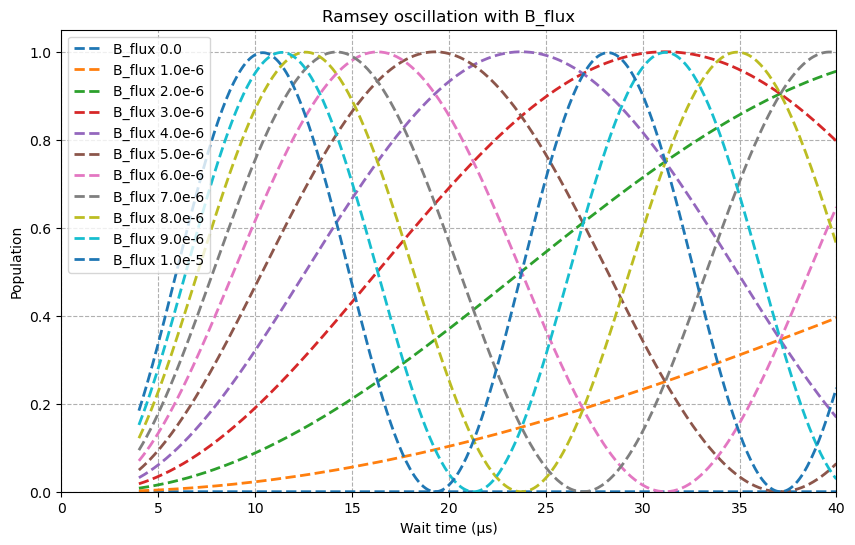

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


In [26]:
waittime = 4:0.1:40
B_span = 0:1e-6:1e-5



L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
for delB in B_span

   
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "e"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
xlim(0, 40)
xlabel("Wait time (μs)")
ylabel("Population")
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()
show()
display(gcf())


In [28]:
Pkg.add("ProgressMeter")
Pkg.add("Distributions")
using Distributions # You'll need to add this package!
using ProgressMeter # For a nice progress bar

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\jewoo\.julia\environments\v1.12\Project.toml`
  [31c24e10] + Distributions v0.25.122
    Manifest No packages added to or removed from `C:\Users\jewoo\.julia\environments\v1.12\Manifest.toml`


In [7]:

# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_1 = 1e-6  # (T) The final shielded noise from the paper
B_rms_2 = 2e-6 # (T) Example for 20 dB worse noise
B_rms_3 = 3e-6 # (T) Example for 20 dB worse noise

# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution_1 = Normal(0, B_rms_1)
noise_distribution_2 = Normal(0, B_rms_2)
noise_distribution_3 = Normal(0, B_rms_3)


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [8]:
waittime = 4:0.1:100
B_span = 0:1e-6:1e-5



L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
for i in 1:10

    delB = rand(noise_distribution_1)
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "e"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
xlim(0, 100)
xlabel("Wait time (μs)")
ylabel("Population")
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()
show()
display(gcf())


UndefVarError: UndefVarError: `Laser` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [9]:
waittime = 4:0.1:100
B_span = 0:1e-6:1e-5



L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB = rand(noise_distribution_1)
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "e"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 100)
xlabel("Wait time (μs)")
ylabel("Population")
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()
show()
display(gcf())


UndefVarError: UndefVarError: `Laser` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [10]:
waittime = 4:0.1:100
B_span = 0:1e-6:1e-5

B_rms_1 = 3e-6 
noise_distribution_1 = Normal(0, B_rms_1)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB = rand(noise_distribution_1)
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "e"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 100)
xlabel("Wait time (μs)")
ylabel("Population")
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()
show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [11]:
waittime = 4:0.1:100
B_span = 0:1e-6:1e-5

B_rms_1 = 3e-6 
noise_distribution_1 = Normal(0, B_rms_1)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB = rand(noise_distribution_1)
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 100)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)
legend(bbox_to_anchor=(1.1, 1))
grid(true, linestyle="--")
show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [12]:
waittime = 4:0.1:100

B_rms_1 = 1e-5 
noise_distribution_1 = Normal(0, B_rms_1)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB = rand(noise_distribution_1)
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 100)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")
legend()
show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [13]:
waittime = 4:0.1:100

B_rms_1 = 1e-6 
noise_distribution_1 = Normal(0, B_rms_1)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB= 0
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        delB = rand(noise_distribution_1)
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 100)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")

show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [14]:
waittime = 4:0.1:100

B_rms_1 = 1e-6 
noise_distribution_1 = Normal(B_rms_1, 1e-7)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB= 0
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        delB = rand(noise_distribution_1)
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 100)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")

show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [15]:
waittime = 4:0.1:200

B_rms_1 = 1e-6 
noise_distribution_1 = Normal(B_rms_1, 1e-7)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB= 0
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        delB = rand(noise_distribution_1)
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 200)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")

show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [16]:
waittime = 4:0.1:200

B_rms_1 = 1e-5 
noise_distribution_1 = Normal(B_rms_1, 1e-6)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB= 0
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        delB = rand(noise_distribution_1)
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 200)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")

show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

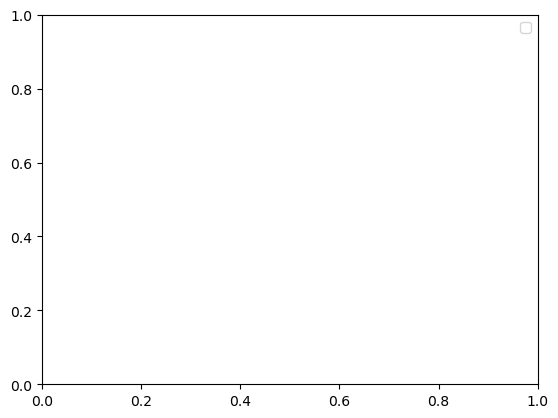

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [17]:
legend()
display(gcf())

In [18]:
waittime = 4:0.1:75

B_rms_1 = 1e-5 
noise_distribution_1 = Normal(0, 1e-5)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB= 0
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        delB = rand(noise_distribution_1)
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 75)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")

show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [19]:
waittime = 4:0.1:100

B_rms_1 = 1e-7
noise_distribution_1 = Normal(0, B_rms_1)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB= 0
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        delB = rand(noise_distribution_1)
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 100)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")

show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.

In [20]:
waittime = 4:0.1:75

B_rms_1 = 1e-5 
noise_distribution_1 = Normal(0, 1e-5)

L4 = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T4 = Chamber(
    iontrap=chain,
    B=4e-1,              # Magnetic field in Tesla
    δB = 0,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L4]
)
polarization!(L4, (x̂ - ẑ)/√2)
wavevector!(L4, (x̂ + ẑ)/√2);
wavelength_from_transition!(L4, C, ("g", "e"), T4)

figure(figsize=(10, 6))
 cnt = 0
 total_x = Float64[];
 total_y = Float64[];
for i in 1:10

    delB= 0
    x = Float64[]
    y = Float64[]

    x1 = Float64[]
    
    y1 = Float64[]
    ct=1;
    for wait in waittime
        delB = rand(noise_distribution_1)
        tspan1 = 0:0.1:wait
        bfield_fluctuation!(T4, delB)
        h1_wait = pulse(T4, tspan1, 4e-6)
        tout1_wait, sol1_wait = timeevolution.schroedinger_dynamic(tspan1, ψ₀, h1_wait)
        excited_pop1_wait = expect(ionprojector(T4, "g"), sol1_wait)

        push!(x, tout1_wait[end])
        push!(y, real(excited_pop1_wait[end]))
        if(i==1)
            push!(total_x, tout1_wait[end])
            push!(total_y, real(excited_pop1_wait[end]))
        else
            total_y[ct] += real(excited_pop1_wait[end])
            ct+=1;
        end
    end
    plot(x, y, label="B_flux $(delB)", color="C$cnt", linestyle="--", linewidth=2)
    cnt += 1
end
plot(total_x, total_y ./ 10, label="Average", color="black", linewidth=2)
xlim(0, 75)
xlabel("Wait time (μs)")
ylabel("Ground State Population") # Changed label
title("Ramsey oscillation with B_flux")
ylim(0, 1.05)

grid(true, linestyle="--")

show()
display(gcf())


UndefVarError: UndefVarError: `Normal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in Distributions.